# Triangulate data from multiple Sleap networks

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Requires `sleap` (https://sleap.ai/index.html) and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

# Load in the Sleap data files

In [2]:
from sleap.io.dataset import Labels
import os
import re
import aniposelib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from copy import copy

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import triangulate_sleap

Load the calibration we did above. Make sure the file name is correct!

In [5]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [6]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ['/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedVentral.slp']

This will load in the Sleap points and the calibration. You can restrict to a certain number of videos using the `match_video` option, which uses usual file matching syntax (`*` matches anything, so `'*11.15.23*'` will match any videos that have 11.15.23 in the name)

In [7]:
camgroup, ptsall = triangulate_sleap.load_sleap_points(sleapfiles, 'calibration.toml', match_video='*11.15.23*')

/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:231: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.98Vcon-11.15.23_Trial20_0RampcamC.mp4 in Sleap file multiple times
  warn(f'Video {v1name} in Sleap file multiple times')
/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:231: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/1V-11.15.23_Trial9_1.4RampcamC.mp4 in Sleap file multiple times
  warn(f'Video {v1name} in Sleap file multiple times')


Found 42675 frames across 4 matched videos


Then this triangulates the points and computes the reprojections.

In [8]:
ptsall3d = triangulate_sleap.triangulate_points(camgroup, ptsall)



## Checking reprojections


100%|█████████████████████████| 42675/42675 [00:11<00:00, 3573.57it/s]


Finally, you can check the reprojections by plotting them. This will show the camera views, with red points representing the original tracked points, yellow crosses for the reprojected points, and yellow lines connecting the same point.

frame == 113 and video == "1V-11.15.23_Trial9_1.4RampCAMERA.mp4"


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_34863/2466124920.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


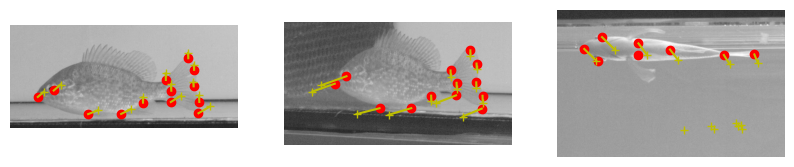

In [9]:
fig = triangulate_sleap.plot_reprojected_points(ptsall3d, 20000, 
                                          videopath='/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos',
                                          zoom=True)
fig.show()


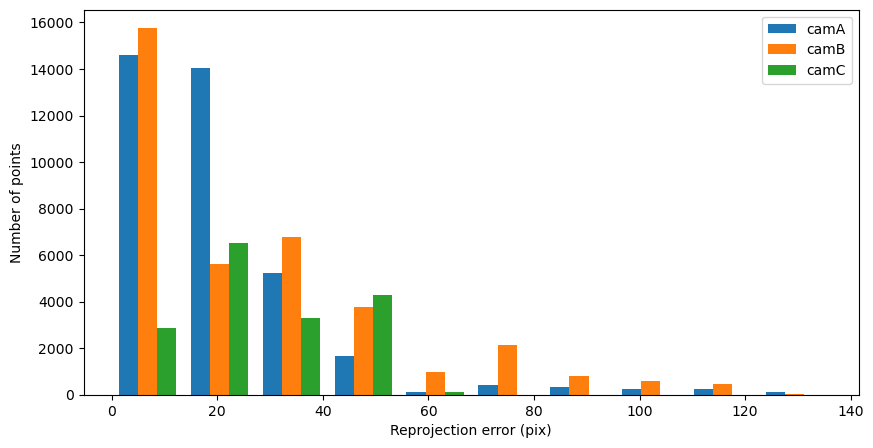

In [10]:
plt.hist(ptsall3d.loc[:,(slice(None),'err')])
plt.legend(camgroup.get_names())
plt.xlabel('Reprojection error (pix)')
plt.ylabel('Number of points')
plt.show()

In [18]:
ptsall3d.index.get_level_values(2).unique()

Index(['Snout', 'Left_eye', 'Right_eye', 'Left_pelvic', 'Right_pelvic', 'Anus',
       'Peduncle_dorsal', 'Peduncle_middle', 'Peduncle_ventral',
       'Caudal_dorsal_tip', 'Caudal_dorsal_lobe', 'Caudal_middle',
       'Caudal_ventral_lobe', 'Caudal_ventral_tip', 'Anal_insertion'],
      dtype='object', name='node')

In [20]:
camgroup1 = triangulate_sleap.refine_calibration(camgroup, ptsall3d, 40, outfile='calibration-refined.toml') #, ['Snout','Left_eye', 'Anus', 'Caudal_ventral_tip'])

17068/42675 points visible in all cameras
8532/42675 (20%) points below maximum error
error:  20.615670326666432
n_samples: 200
{(0, 1): (2665, array([16.13585252, 27.92080187])),
 (0, 2): (2665, array([16.16799375, 21.63049159])),
 (1, 2): (2665, array([12.69513427, 25.66662245]))}
error: 20.98, mu: 16.2, ratio: 0.186
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3833e+05                                    3.72e+07    
       1              2         1.2462e+04      1.26e+05       8.85e+02       8.56e+06    
       2              4         4.0873e+03      8.37e+03       3.21e+02       1.52e+06    
       3              5         3.6813e+03      4.06e+02       7.15e+01       1.12e+05    
       4              8         3.6791e+03      2.22e+00       3.91e+01       2.25e+04    
       5              9         3.6771e+03      1.98e+00       7.72e+01       5.03e+04    
       6             10         3.6763e+03

In [13]:
ptsall3d2 = triangulate_sleap.triangulate_points(camgroup1, ptsall)



## Checking reprojections


100%|█████████████████████████| 42675/42675 [00:10<00:00, 4004.32it/s]


frame == 113 and video == "1V-11.15.23_Trial9_1.4RampCAMERA.mp4"


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_34863/2415620306.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


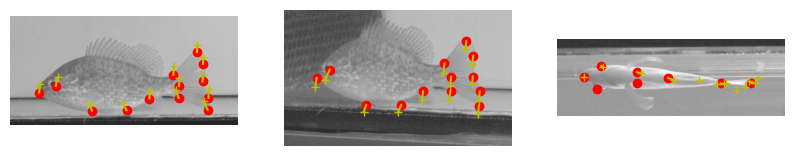

In [14]:
fig = triangulate_sleap.plot_reprojected_points(ptsall3d2, 20000, 
                                          videopath='/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos',
                                          zoom=True)
fig.show()


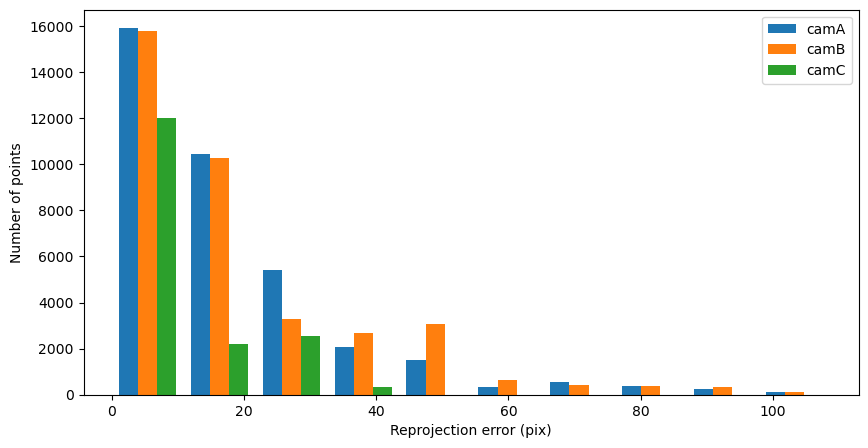

In [15]:
plt.hist(ptsall3d2.loc[:,(slice(None),'err')])
plt.legend(camgroup.get_names())
plt.xlabel('Reprojection error (pix)')
plt.ylabel('Number of points')
plt.show()

These are the median reprojection errors. Make sure they're not too big.

In [16]:
ptsall3d2.loc[:,(slice(None), 'err')].groupby(level=2).median()

camera,camA,camB,camC
var,err,err,err
node,,,
Anal_insertion,13.041192,13.544423,NaN
Anus,13.458535,12.583088,8.474770
Caudal_dorsal_lobe,14.252586,14.882368,NaN
Caudal_dorsal_tip,12.324426,12.938436,NaN
Caudal_middle,13.632636,14.233821,NaN
Caudal_ventral_lobe,13.315979,13.931017,NaN
Caudal_ventral_tip,15.194638,13.562384,5.617649
Left_eye,14.386722,16.195218,4.586391


## Rotate to correct axes

The original calibrated data is aligned to arbitrary axes. Here, based on clicked points along the axes, we rotate the data so that the axes make sense

In [27]:
axesdatafile = '/Users/etytel01/Documents/2024/StephenAcceleration/3DCorrections/11.15.23Correction3D/11.15.23Correction3DDLTdv8_data_xypts.csv'

axesdata = pd.read_csv(axesdatafile)
axesdata

,pt1_cam1_X,pt1_cam1_Y,pt1_cam2_X,pt1_cam2_Y,pt1_cam3_X,pt1_cam3_Y,pt2_cam1_X,pt2_cam1_Y,pt2_cam2_X,pt2_cam2_Y,...,pt3_cam2_X,pt3_cam2_Y,pt3_cam3_X,pt3_cam3_Y,pt4_cam1_X,pt4_cam1_Y,pt4_cam2_X,pt4_cam2_Y,pt4_cam3_X,pt4_cam3_Y
0,NaN,NaN,780.118346,666.172313,955.412941,455.476556,1210.406005,582.477448,1241.941102,679.421097,...,769.925204,666.239155,955.907765,430.049385,746.830115,132.87839,776.298294,165.771792,NaN,NaN


In [45]:
cn = axesdata.columns
for i, camname in enumerate(camgroup1.get_names()):
    cn = [re.sub('cam{}'.format(i+1), camname, n) for n in cn]

cn = [re.sub('X', 'x', n) for n in cn]
cn = [re.sub('Y', 'y', n) for n in cn]

cn

['pt1_camA_x',
 'pt1_camA_y',
 'pt1_camB_x',
 'pt1_camB_y',
 'pt1_camC_x',
 'pt1_camC_y',
 'pt2_camA_x',
 'pt2_camA_y',
 'pt2_camB_x',
 'pt2_camB_y',
 'pt2_camC_x',
 'pt2_camC_y',
 'pt3_camA_x',
 'pt3_camA_y',
 'pt3_camB_x',
 'pt3_camB_y',
 'pt3_camC_x',
 'pt3_camC_y',
 'pt4_camA_x',
 'pt4_camA_y',
 'pt4_camB_x',
 'pt4_camB_y',
 'pt4_camC_x',
 'pt4_camC_y']

In [46]:
cn = [n.split('_') for n in cn]
#cn = [[n[1], n[2], n[0]] for n in cn]

axesdata1 = copy(axesdata)
axesdata1.columns = pd.MultiIndex.from_tuples(cn)
axesdata1 = axesdata1.stack(level=0)

axesdata1

camA                     camB                     camC  \
                 x           y            x           y            x   
0 pt1          NaN         NaN   780.118346  666.172313   955.412941   
  pt2  1210.406005  582.477448  1241.941102  679.421097  1494.181879   
  pt3          NaN         NaN   769.925204  666.239155   955.907765   
  pt4   746.830115  132.878390   776.298294  165.771792          NaN   

                   
                y  
0 pt1  455.476556  
  pt2  450.986010  
  pt3  430.049385  
  pt4         NaN

In [47]:
axesdata3d = triangulate_sleap.triangulate_points(camgroup1, axesdata1)



## Checking reprojections


100%|█████████████████████████████████| 4/4 [00:00<00:00, 1589.20it/s]


In [48]:
axesdata3d

camA                     camB                     camC  \
                 x           y            x           y            x   
0 pt1          NaN         NaN   780.118346  666.172313   955.412941   
  pt2  1210.406005  582.477448  1241.941102  679.421097  1494.181879   
  pt3          NaN         NaN   769.925204  666.239155   955.907765   
  pt4   746.830115  132.878390   776.298294  165.771792          NaN   

                          3D                                  camA  \
                y          x           y            z           Xr   
0 pt1  455.476556  -8.596211  104.912413  1896.342585   755.285179   
  pt2  450.986010  83.568697   84.775288  1889.020351  1211.954182   
  pt3  430.049385  -8.579026  104.575405  1891.647343   752.777782   
  pt4         NaN -26.687934    9.817532  1887.167275   748.718850   

                          camB                     camC              \
               Yr           Xr          Yr           Xr          Yr   
0 pt1  587.961713   782.797491  666.403670   952.473192  454.152559   
  pt2  579.894115  1232.872174  680.946818  1502.335426  453.390394   
  pt3  588.491904   773.447784  666.534628   952.086925  428.307895   
  pt4  119.593897   774.344121  179.578758   822.123067  590.582387   

            camA       camB      camC  
             err        err       err  
0 pt1        NaN   2.689116  3.224142  
  pt2   3.011721   9.196373  8.500670  
  pt3        NaN   3.534950  4.199001  
  pt4  13.418088  13.944573       NaN

In [ ]:
# CONTINUE here
# Get the 3D points, use Gram-Schmidt orthogonalization to make a rotation matrix, then apply to ptsall3d2

Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [255]:
ptsall3d2.head()

camera                                                          camA  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1243.096309   
                                           Left_eye      1268.688036   
                                           Right_eye             NaN   
                                           Left_pelvic   1338.631047   
                                           Right_pelvic          NaN   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         571.946166   
                                           Left_eye      551.738507   
                                           Right_eye            NaN   
                                           Left_pelvic   594.236171   
                                           Right_pelvic         NaN   

camera                                                          camB  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1169.338538   
                                           Left_eye      1191.585528   
                                           Right_eye             NaN   
                                           Left_pelvic   1276.323979   
                                           Right_pelvic          NaN   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout          665.92632   
                                           Left_eye      646.189286   
                                           Right_eye            NaN   
                                           Left_pelvic   694.770316   
                                           Right_pelvic         NaN   

camera                                                          camC  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1505.471619   
                                           Left_eye      1534.239747   
                                           Right_eye     1534.749842   
                                           Left_pelvic   1618.115309   
                                           Right_pelvic  1617.768282   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         154.143312   
                                           Left_eye      131.362774   
                                           Right_eye     175.599816   
                                           Left_pelvic   146.032301   
                                           Right_pelvic  161.292322   

camera                                                          3D             \
var                                                              x          y   
video                                frame node                                 
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         75.623627  74.138335   
                                           Left_eye      79.650971  69.533687   
                                           Right_eye           NaN        NaN   
                                           Left_pelvic   92.386632  74.19963

In [256]:
ptsall3dflat = copy(ptsall3d2)
ptsall3dflat.columns = ['_'.join(reversed(c)) for c in ptsall3dflat.columns.to_flat_index()]
ptsall3dflat.reset_index(inplace=True)
ptsall3dflat.head()

,video,frame,node,x_camA,y_camA,x_camB,y_camB,x_camC,y_camC,x_3D,...,z_3D,Xr_camA,Yr_camA,Xr_camB,Yr_camB,Xr_camC,Yr_camC,err_camA,err_camB,err_camC
0,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Snout,1243.096309,571.946166,1169.338538,665.92632,1505.471619,154.143312,75.623627,...,1839.609535,1240.057097,570.651252,1169.829640,666.446391,1508.583126,153.634521,3.303576,0.715301,3.152831
1,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Left_eye,1268.688036,551.738507,1191.585528,646.189286,1534.239747,131.362774,79.650971,...,1834.409815,1269.409521,551.935903,1191.717928,646.242711,1533.246950,131.438593,0.748001,0.142772,0.995687
2,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Right_eye,NaN,NaN,NaN,NaN,1534.749842,175.599816,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Left_pelvic,1338.631047,594.236171,1276.323979,694.770316,1618.115309,146.032301,92.386632,...,1839.040156,1337.483420,592.311810,1273.703410,695.937921,1622.144330,146.238530,2.240584,2.868917,4.034295
4,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Right_pelvic,NaN,NaN,NaN,NaN,1617.768282,161.292322,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And save! Remember to adjust the file name as needed.

In [99]:
ptsall3dflat.to_csv('points3d.csv', index=False)